# Final Project DS6105 Data Science

## Body Performance Data 

We're going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. SHAP Analysis
7. AutoML for Modelling
8. Using Keras
9. Feature Importance on Best Model


## 1. Problem definition
People have a sedentary lifestyle and have less physical exercise than earlier in today's world. We want to classify the person's body health with parameters such as age, gender, weight, vitals sign information, and the amount of exercise they perform. We will calculate their body class based on A to D. A being the best and D the worst.


## 2. Data

The original data came from Korea Sports Promotion Foundation. https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1


We would be using a version available on Kaggle. https://www.kaggle.com/datasets/kukuroo3/body-performance-data


## 3. Evaluation
We will find out which of the model find out which model predict the body classify with highest accuracy and the data feature which contribute to the having better body (A Type)


## 4. Features
List of all the features in the dataset
- `age` : 20 to 64
- `gender` : F,M 
- `height_cm` : (If you want to convert to feet, divide by 30.48)
- `weight_kg`
- `body fat_%`
- `diastolic` : diastolic blood pressure (min)
- `systolic` : systolic blood pressure (min)
- `gripForce`
- `sit and bend forward_cm`
- `sit-ups counts`
- `broad jump_cm`
- `class` : A,B,C,D ( A: best) / stratified 


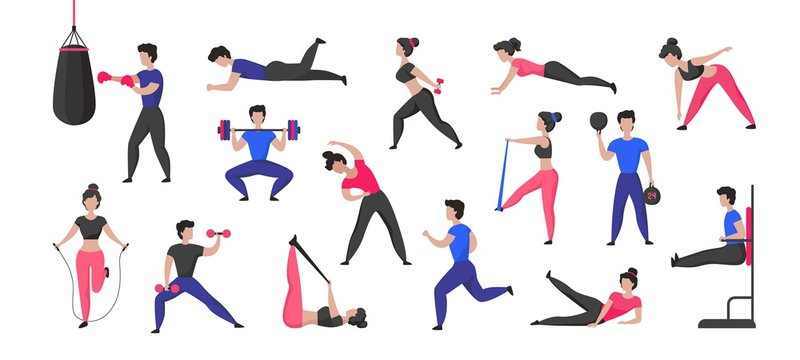




## Preparing the tools

We're going to use pandas, Matplotlib and NumPy for data analysis and manipulation.

In [122]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install shap
!pip install probatus==1.7.0


!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o



Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [167]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
import xgboost as xgb

# Turn the categories into numbers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

from scipy.stats import loguniform
from scipy.stats import randint
from sklearn.metrics import make_scorer

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# SHAP
import shap
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import seaborn as sns

# Keras
import tensorflow as tf
from tensorflow.keras import layers

## Load data 

In [124]:
## Load data 
df = pd.read_csv('https://raw.githubusercontent.com/pratikg17neu/DS_6105/main/FinalProject/bodyPerformance.csv')
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


### Renaming the columns

In [125]:
#Rename columns
df = df.rename(columns={"body fat_%":"body_fat", "height_cm":"height", "weight_kg":"weight", "sit and bend forward_cm":"bend_forward", "gripForce":"grip_force","sit-ups counts":"sit_ups", "broad jump_cm":"broad_jump"})
df.head()

,age,gender,height,weight,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


## Data Exploration (exploratory data analysis or EDA)

The goal here is to find out more about the data

1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?

In [126]:
df.head()

,age,gender,height,weight,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [127]:
df.tail()

,age,gender,height,weight,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump,class
13388,25.0,M,172.1,71.8,16.2,74.0,141.0,35.8,17.4,47.0,198.0,C
13389,21.0,M,179.7,63.9,12.1,74.0,128.0,33.0,1.1,48.0,167.0,D
13390,39.0,M,177.2,80.5,20.1,78.0,132.0,63.5,16.4,45.0,229.0,A
13391,64.0,F,146.1,57.7,40.4,68.0,121.0,19.3,9.2,0.0,75.0,D
13392,34.0,M,164.0,66.1,19.5,82.0,150.0,35.9,7.1,51.0,180.0,C


In [128]:
# Let's find out how many of each class there
df["class"].value_counts()

C    3349
D    3349
A    3348
B    3347
Name: class, dtype: int64

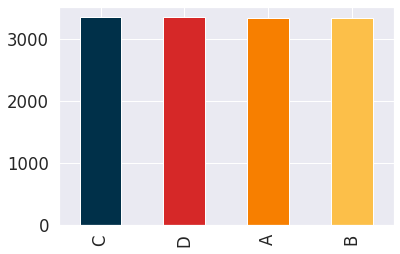

In [129]:
df["class"].value_counts().plot(kind="bar", color=[ "#003049", "#d62828","#f77f00", "#fcbf49"]);

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           13393 non-null  float64
 1   gender        13393 non-null  object 
 2   height        13393 non-null  float64
 3   weight        13393 non-null  float64
 4   body_fat      13393 non-null  float64
 5   diastolic     13393 non-null  float64
 6   systolic      13393 non-null  float64
 7   grip_force    13393 non-null  float64
 8   bend_forward  13393 non-null  float64
 9   sit_ups       13393 non-null  float64
 10  broad_jump    13393 non-null  float64
 11  class         13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [131]:
# Are there any missing values?
df.isna().sum()

age             0
gender          0
height          0
weight          0
body_fat        0
diastolic       0
systolic        0
grip_force      0
bend_forward    0
sit_ups         0
broad_jump      0
class           0
dtype: int64

In [132]:
df.describe()

,age,height,weight,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627
std,13.625639,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000
min,21.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000
25%,25.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000
50%,32.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000
75%,48.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000
max,64.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000


### Body Performance Grade according to Gender 

In [133]:
df.gender.value_counts()

M    8467
F    4926
Name: gender, dtype: int64

In [134]:
# Compare target column with gender column
pd.crosstab(df["class"], df.gender)

gender,F,M
class,,
A,1484,1864
B,1185,2162
C,1112,2237
D,1145,2204


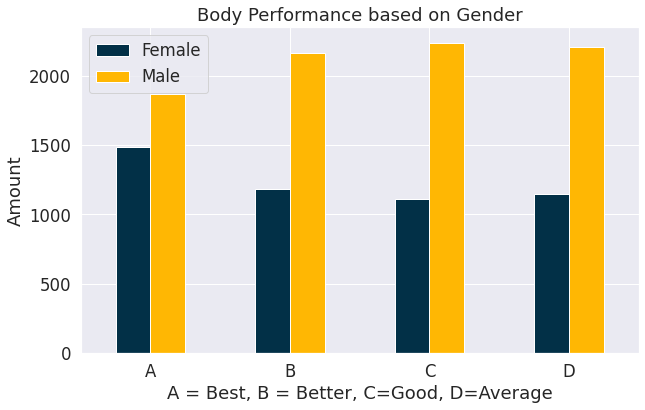

In [135]:
# Create a plot of crosstab
pd.crosstab(df["class"], df["gender"]).plot(kind="bar",
                                    figsize=(10, 6),
                                     color=["#023047","#ffb703"])

plt.title("Body Performance based on Gender")
plt.xlabel("A = Best, B = Better, C=Good, D=Average")
plt.ylabel("Amount")
plt.legend(["Female", "Male"]);
plt.xticks(rotation=0);

### Body Fat vs Gender

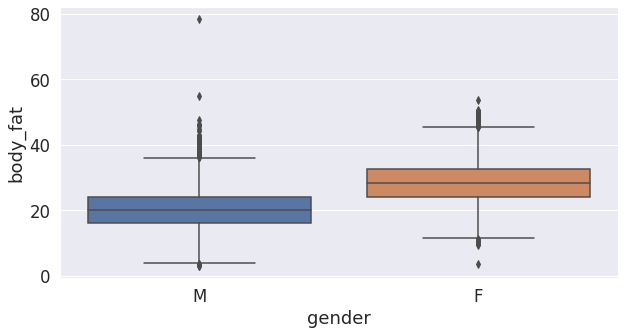

In [136]:
#Gender and body fat
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
sns.boxplot(x="gender", y="body_fat", data=df, ax=ax)

### Grip Force vs Gender

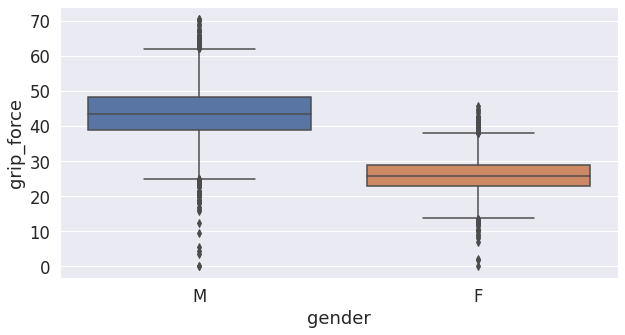

In [137]:
#Gender and gripforce
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
sns.boxplot(x="gender", y="grip_force", data=df, ax=ax)

### Distribution of Data

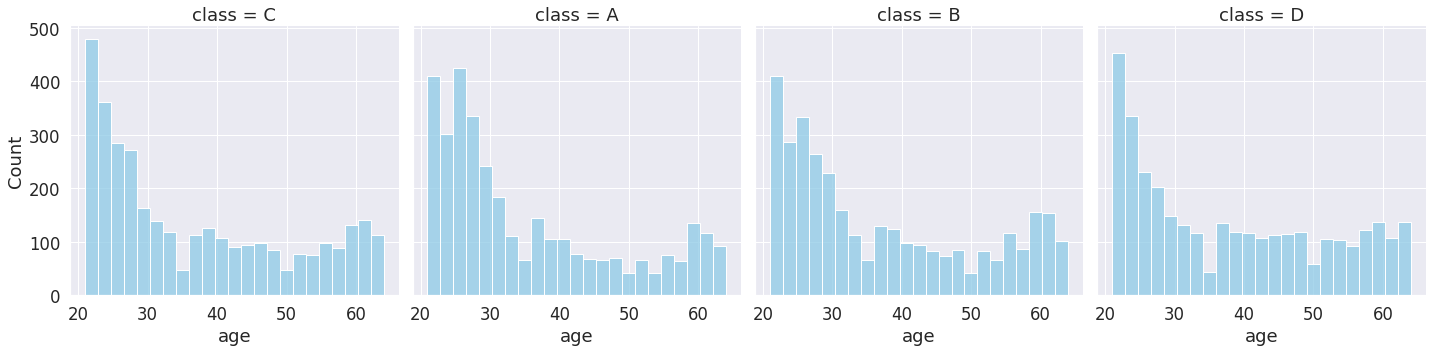

In [138]:

sns.displot(df, x="age",col="class", color="#8ecae6");

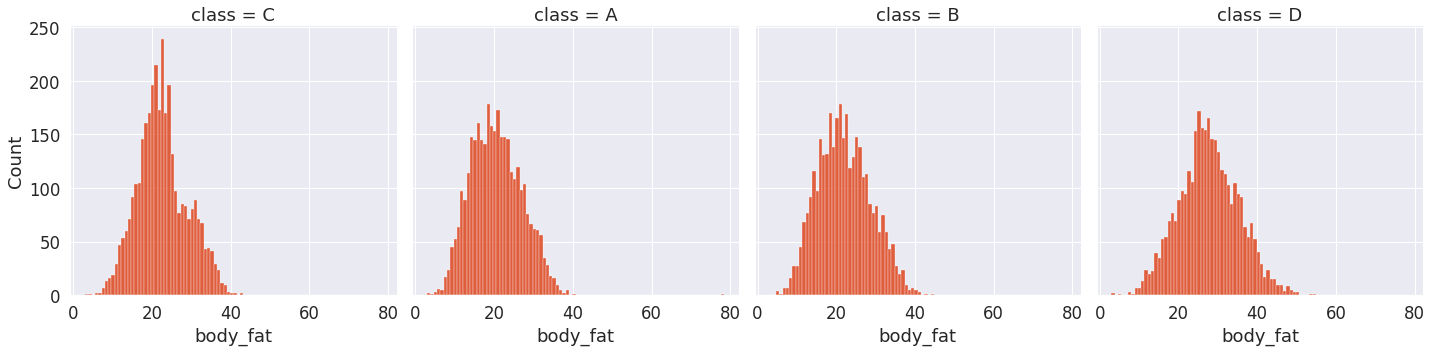

In [139]:
sns.displot(df, x="body_fat",col="class",color="#dc2f02");


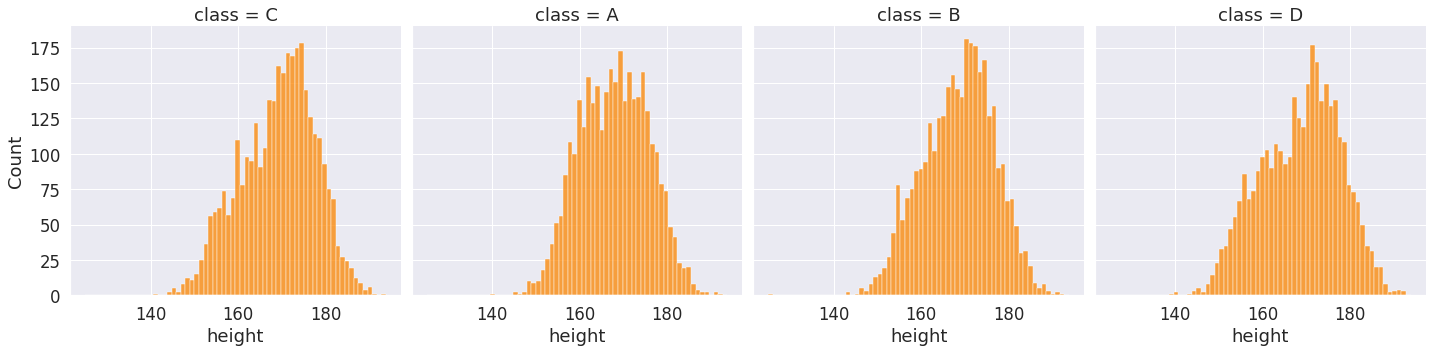

In [140]:
sns.displot(df, x="height",col="class",color="#fb8500");


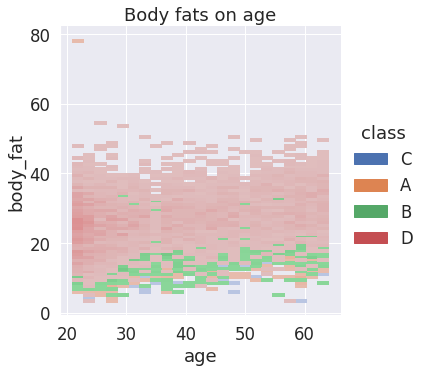

In [141]:
palette =[ "#003049", "#d62828","#f77f00", "#fcbf49"]
sns.displot(data=df, x="age",y="body_fat",hue="class" ).set(title="Body fats on age");

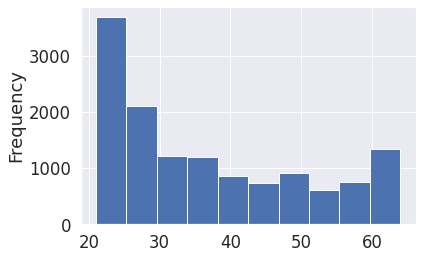

In [142]:
# Check the distribution of the age column with a histogram
df.age.plot.hist();

### Correlation Matrix

In [143]:
# Make a correlation matrix
df.corr()

,age,height,weight,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump
age,1.000000,-0.293980,-0.099966,0.242302,0.158508,0.211167,-0.179583,-0.070033,-0.544581,-0.435172
height,-0.293980,1.000000,0.734909,-0.515440,0.145933,0.210186,0.735024,-0.221970,0.500424,0.674589
weight,-0.099966,0.734909,1.000000,-0.084065,0.262317,0.338943,0.700119,-0.296249,0.294899,0.479564
body_fat,0.242302,-0.515440,-0.084065,1.000000,0.048059,-0.030376,-0.541788,-0.071225,-0.608912,-0.673273
diastolic,0.158508,0.145933,0.262317,0.048059,1.000000,0.676309,0.202062,-0.072098,0.016547,0.097243
systolic,0.211167,0.210186,0.338943,-0.030376,0.676309,1.000000,0.286012,-0.082434,0.056276,0.152894
grip_force,-0.179583,0.735024,0.700119,-0.541788,0.202062,0.286012,1.000000,-0.112577,0.576669,0.746853
bend_forward,-0.070033,-0.221970,-0.296249,-0.071225,-0.072098,-0.082434,-0.112577,1.000000,0.177153,0.026487
sit_ups,-0.544581,0.500424,0.294899,-0.608912,0.016547,0.056276,0.576669,0.177153,1.000000,0.748273
broad_jump,-0.435172,0.674589,0.479564,-0.673273,0.097243,0.152894,0.746853,0.026487,0.748273,1.000000


(10.5, -0.5)

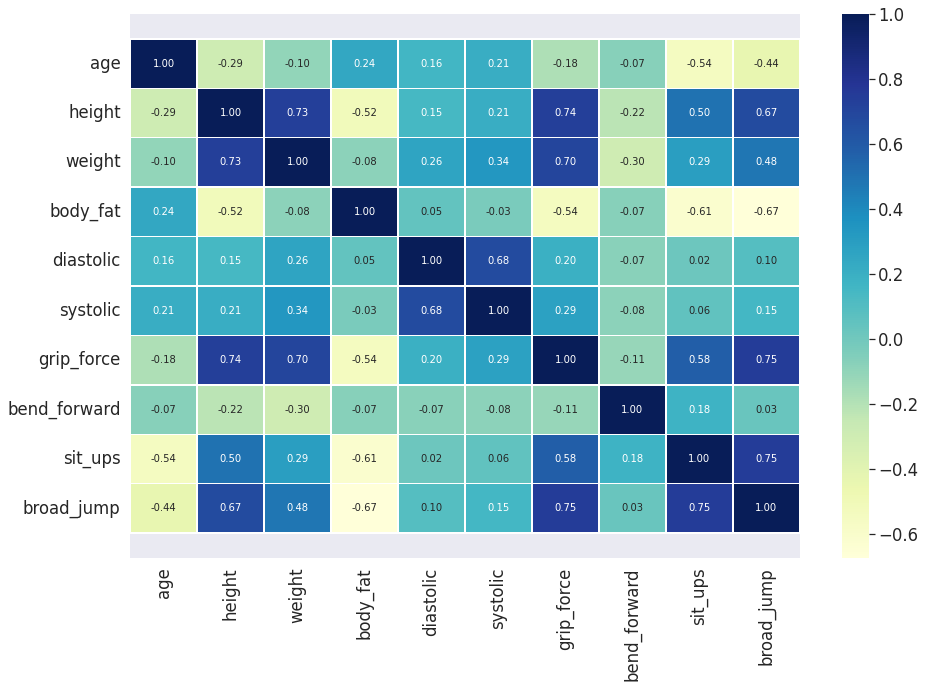

In [144]:
# Let's make our correlation matrix a little prettier
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## 5. Modelling

In [145]:
df.head()

,age,gender,height,weight,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [146]:
# Split data into X and y
X = df.drop("class", axis=1)

y = df["class"]

In [147]:
X

,age,gender,height,weight,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0
...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,M,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0
13389,21.0,M,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0
13390,39.0,M,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0
13391,64.0,F,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0


## Feature Scaling

Encoding the `gender` variable

In [148]:

categorical_features = ["gender"]
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot",
                                   one_hot,
                                   categorical_features)],
                                   remainder="passthrough")

transformed_X = transformer.fit_transform(X)
transformed_X




array([[  0. ,   1. ,  27. , ...,  18.4,  60. , 217. ],
       [  0. ,   1. ,  25. , ...,  16.3,  53. , 229. ],
       [  0. ,   1. ,  31. , ...,  12. ,  49. , 181. ],
       ...,
       [  0. ,   1. ,  39. , ...,  16.4,  45. , 229. ],
       [  1. ,   0. ,  64. , ...,   9.2,   0. ,  75. ],
       [  0. ,   1. ,  34. , ...,   7.1,  51. , 180. ]])

In [149]:
X.head()

,age,gender,height,weight,body_fat,diastolic,systolic,grip_force,bend_forward,sit_ups,broad_jump
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0


In [150]:
pd.DataFrame(transformed_X)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,1.0,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0
1,0.0,1.0,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0
2,0.0,1.0,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0
3,0.0,1.0,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0
4,0.0,1.0,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13388,0.0,1.0,25.0,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0
13389,0.0,1.0,21.0,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0
13390,0.0,1.0,39.0,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0
13391,1.0,0.0,64.0,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0


In [151]:
y

0        C
1        A
2        C
3        B
4        B
        ..
13388    C
13389    D
13390    A
13391    D
13392    C
Name: class, Length: 13393, dtype: object

In [152]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(transformed_X,
                                                    y, 
                                                    test_size=0.2)



In [153]:
X_train

array([[  0. ,   1. ,  27. , ...,  22.5,  50. , 189. ],
       [  1. ,   0. ,  22. , ...,  32.2,  35. , 143. ],
       [  1. ,   0. ,  49. , ...,  19.2,   8. , 148. ],
       ...,
       [  1. ,   0. ,  27. , ...,  21.4,  47. , 182. ],
       [  1. ,   0. ,  21. , ...,  20.3,  43. , 166. ],
       [  0. ,   1. ,  22. , ...,  16.7,  60. , 225. ]])

In [154]:
y_train, len(y_train)

(8045     D
 12964    B
 12642    D
 9002     C
 12596    A
         ..
 11964    B
 5191     D
 5390     A
 860      D
 7270     B
 Name: class, Length: 10714, dtype: object, 10714)

Now we've got our data split into training and test sets, it's time to build a machine learning model.

We'll train it (find the patterns) on the training set.

And we'll test it (use the patterns) on the test set.

We're going to try different machine learning models:
1. Logistic Regression 
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier
4. DecisionTreeClassifier
5. SVC Training Accuracy: 
6. GradientBoostingClassifier
7. AdaBoostClassifier
8. XGBClassifier


In [35]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(solver="liblinear"),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Decision Tree":   DecisionTreeClassifier(),
           "SVC": SVC(),
          "Gradient Boosting": GradientBoostingClassifier(),
          "AdaBoostClassifier": AdaBoostClassifier(),
          "XGB": xgb.XGBClassifier()
          }

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Set random seed
        np.random.seed(42)
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [36]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

{'AdaBoostClassifier': 0.5923852183650616,
 'Decision Tree': 0.6599477416946622,
 'Gradient Boosting': 0.7278835386338186,
 'KNN': 0.5655095184770437,
 'Logistic Regression': 0.5912653975363942,
 'Random Forest': 0.740574841358716,
 'SVC': 0.6013437849944009,
 'XGB': 0.7051138484509145}

### Model Comparison

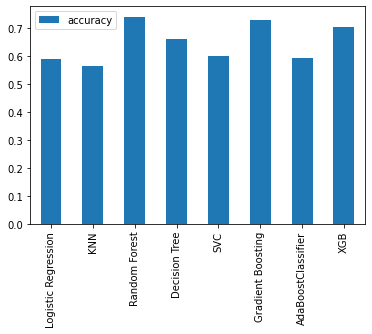

In [37]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

The default model dont provide much accuracy, so we will perform Hyper paramter tuning on the models using GridSearchCv

### Hyperparameter tuning

In [38]:

# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {
    "C": np.logspace(-4, 4, 30),
    "solver": ["liblinear"]
}
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {
    "n_estimators": np.arange(10, 1000, 50),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2)
}
# Create a hyperparameter grid for KNN
knn_grid = {
    "leaf_size": np.arange(0, 50, 2),
    "n_neighbors": range(1, 30),
    "p": [1, 2, 3, 4, 5]
}
dt_grid = {
    "max_depth": [3, None],
    "max_features": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(2, 20, 2),
    "criterion": ["gini", "entropy"]
}
svc_grid = {
    "C": np.logspace(-4, 4, 100),
    "gamma": [1, 0.1, 0.01, 0.001],
    "kernel": ["rbf"]
}
gb_grid = {
    "max_depth": [None, 3, 5, 10],
    'min_samples_split': range(200, 1001, 200),
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}
ada_grid = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': loguniform(0.01, 1),
    "n_estimators": range(1, 30)
}
xgb_grid = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}

##  RandomizedSearchCV on Logistic

In [39]:

# Setup grid hyperparameter search for LogisticRegression
np.random.seed(42)
gs_log_reg = RandomizedSearchCV(LogisticRegression(),
                          param_distributions=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train);

# Check the best hyperparmaters
gs_log_reg.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'C': 417.53189365604004, 'solver': 'liblinear'}

In [40]:
lg_mdl = LogisticRegression(C=4.893900918477489, solver="liblinear")
lg_mdl.fit(X_train, y_train)
lg_mdl.score(X_test, y_test)


0.5920119447555058

In [41]:
np.random.seed(42)
# Setup grid hyperparameter search for LogisticRegression
rf_classifier = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=rf_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
rf_classifier.fit(X_train, y_train);

# Check the best hyperparmaters
rf_classifier.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 310}

In [42]:
rf_mdl = RandomForestClassifier(max_depth= None, min_samples_leaf= 17, min_samples_split= 4, n_estimators= 510)
rf_mdl.fit(X_train, y_train)
rf_mdl.score(X_test, y_test)


0.7293766330720418

In [43]:

np.random.seed(42)
# Setup grid hyperparameter search for KNeighborsClassifier
knn_model = RandomizedSearchCV(KNeighborsClassifier(),
                          param_distributions=knn_grid,
                          cv=5)

# Fit grid hyperparameter search model
knn_model.fit(X_train, y_train);

# Check the best hyperparmaters
knn_model.best_params_

{'leaf_size': 10, 'n_neighbors': 28, 'p': 1}

In [44]:
knn_mdl = KNeighborsClassifier(leaf_size= 46, n_neighbors= 18, p= 2)
knn_mdl.fit(X_train, y_train)
knn_mdl.score(X_test, y_test)


0.5998506905561777

In [45]:

np.random.seed(42)
# Setup grid hyperparameter search for DecisionTreeClassifier
dt_model = RandomizedSearchCV(DecisionTreeClassifier(),
                          param_distributions=dt_grid,
                          cv=5)

# Fit grid hyperparameter search model
dt_model.fit(X_train, y_train);

# Check the best hyperparmaters
dt_model.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 12,
 'min_samples_leaf': 14}

In [46]:
dt_mdl = DecisionTreeClassifier(
criterion= 'entropy',
 max_depth= None,
 max_features= 12,
 min_samples_leaf= 8
 )
dt_mdl.fit(X_train, y_train)
dt_mdl.score(X_test, y_test)


0.6692795819335573

In [47]:
np.random.seed(42)
# Setup grid hyperparameter search for SVC
svc_model = RandomizedSearchCV(SVC(),
                          param_distributions=svc_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
svc_model.fit(X_train, y_train);

# Check the best hyperparmaters
svc_model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'C': 1.592282793341094, 'gamma': 0.01, 'kernel': 'rbf'}

In [48]:
svc_mdl = SVC(C= 100, gamma= 0.0001, kernel= 'rbf')
svc_mdl.fit(X_train, y_train)
svc_mdl.score(X_test, y_test)


0.7021276595744681

In [49]:
np.random.seed(42)
# Setup grid hyperparameter search for GradientBoostingClassifier
gb_model = RandomizedSearchCV(GradientBoostingClassifier(),
                          param_distributions=gb_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gb_model.fit(X_train, y_train);

# Check the best hyperparmaters
gb_model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'learning_rate': 0.17177621112338376,
 'max_depth': 3,
 'max_leaf_nodes': 100,
 'min_samples_split': 1000,
 'n_estimators': 500}

In [50]:
gb_mdl = GradientBoostingClassifier(learning_rate= 0.12938724507386712,
 max_depth= 5,
 max_leaf_nodes= 50,
 min_samples_split= 600,
 n_estimators= 200)
gb_mdl.fit(X_train, y_train)
gb_mdl.score(X_test, y_test)


0.7513997760358343

In [51]:
np.random.seed(42)
# Setup grid hyperparameter search for AdaBoostClassifier
ada_model = RandomizedSearchCV(AdaBoostClassifier(),
                          param_distributions=ada_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
ada_model.fit(X_train, y_train);

# Check the best hyperparmaters
ada_model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'algorithm': 'SAMME.R',
 'learning_rate': 0.16722697006183673,
 'n_estimators': 29}

In [52]:
ada_mdl = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate=  0.5186049086272381, n_estimators= 27)
ada_mdl.fit(X_train, y_train)
ada_mdl.score(X_test, y_test)


0.574468085106383

In [53]:

np.random.seed(42)
# Setup grid hyperparameter search for XGBClassifier
xgb_model = RandomizedSearchCV(xgb.XGBClassifier(),
                          param_distributions=xgb_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
xgb_model.fit(X_train, y_train);

# Check the best hyperparmaters
xgb_model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'colsample_bytree': 0.4,
 'gamma': 0.1,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 200}

In [54]:
xgb_mdl = xgb.XGBClassifier(colsample_bytree= 0.7,
 gamma= 0.4,
 learning_rate= 0.15,
 max_depth= 5,
 min_child_weight= 3,
 n_estimators= 200)
xgb_mdl.fit(X_train, y_train)
xgb_mdl.score(X_test, y_test)


0.7629712579320642

## Using GridSearchCV on Top Performing Models


1. RandomForestClassifier
2. GradientBoostingClassifier
3. DecisionTreeClassifier
4. XGBClassifier

In [55]:
np.random.seed(42)
# Setup grid hyperparameter search for LogisticRegression

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": [510],
           "max_depth": [None],
           "min_samples_split": np.arange(10, 20, 2),
           "min_samples_leaf": [12]}


rf_g_classifier = GridSearchCV(RandomForestClassifier(),
                          param_grid=rf_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
rf_g_classifier.fit(X_train, y_train);

# Check the best hyperparmaters
rf_g_classifier.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 510}

In [56]:
rf_mdl = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 10, n_estimators= 510)
rf_mdl.fit(X_train, y_train)
rf_mdl.score(X_test, y_test)


0.7476670399402762

In [57]:
np.random.seed(42)
gb_grid = {
    "max_depth": [10],
     'min_samples_split':[400],
        "n_estimators": [200],
    "max_leaf_nodes": [10, 100],
    "learning_rate": [0.07121341498159994],
}

# Setup grid hyperparameter search for GradientBoostingClassifier
gb_model = GridSearchCV(GradientBoostingClassifier(),
                          param_grid=gb_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gb_model.fit(X_train, y_train);

# Check the best hyperparmaters
gb_model.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'learning_rate': 0.07121341498159994,
 'max_depth': 10,
 'max_leaf_nodes': 100,
 'min_samples_split': 400,
 'n_estimators': 200}

In [58]:
gb_g_mdl = GradientBoostingClassifier(learning_rate= 0.07121341498159994,
 max_depth= 10,
 max_leaf_nodes= 10,
 min_samples_split= 400,
 n_estimators= 200)
gb_g_mdl.fit(X_train, y_train)
gb_g_mdl.score(X_test, y_test)


0.7458006718924972

In [59]:
np.random.seed(42)
dt_grid = {
   "max_depth": [5,None],
              "max_features":[1,12],
              "min_samples_leaf":[1,10],
              "criterion": ["gini", "entropy"]
}


# Setup grid hyperparameter search for DecisionTreeClassifier
dt_model = GridSearchCV(DecisionTreeClassifier(),
                          param_grid=dt_grid,
                          cv=5)

# Fit grid hyperparameter search model
dt_model.fit(X_train, y_train);

# Check the best hyperparmaters
dt_model.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 10}

In [60]:
dt_mdl = DecisionTreeClassifier(
criterion= 'gini',
 max_depth= None,
 max_features= 12,
 min_samples_leaf= 10
 )
dt_mdl.fit(X_train, y_train)
dt_mdl.score(X_test, y_test)


0.6860768943635684

In [61]:
np.random.seed(42)
xgb_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.15],
    "max_depth": [3],
    "min_child_weight": [3],
    "gamma": [0.49],
    "colsample_bytree": [0.7]
}

# Setup grid hyperparameter search for XGBClassifier
xgb_model = GridSearchCV(xgb.XGBClassifier(),
                          param_grid=xgb_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
xgb_model.fit(X_train, y_train);

# Check the best hyperparmaters
xgb_model.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'colsample_bytree': 0.7,
 'gamma': 0.49,
 'learning_rate': 0.15,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 200}

In [62]:
xgb_mdl = xgb.XGBClassifier(colsample_bytree= 0.7,
 gamma= 0.49,
 learning_rate= 0.15,
 max_depth= 5,
 min_child_weight= 3,
 n_estimators= 200)
xgb_mdl.fit(X_train, y_train)
xgb_mdl.score(X_test, y_test)


0.7693169092945129

In [63]:
# Put models in a dictionary
gs_models = {
    'Random Forest': RandomForestClassifier(max_depth=None,
            min_samples_leaf=1, min_samples_split=10,
            n_estimators=510),
    'Decision Tree': DecisionTreeClassifier(criterion='gini',
            max_depth=None, max_features=12, min_samples_leaf=10),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGB': xgb.XGBClassifier(
        colsample_bytree=0.7,
        gamma=0.49,
        learning_rate=0.15,
        max_depth=5,
        min_child_weight=3,
        n_estimators=200,
        ),
    }

In [64]:
grid_search_model_scores = fit_and_score(models=gs_models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

grid_search_model_scores

{'Decision Tree': 0.6860768943635684,
 'Gradient Boosting': 0.7278835386338186,
 'Random Forest': 0.7476670399402762,
 'XGB': 0.7693169092945129}

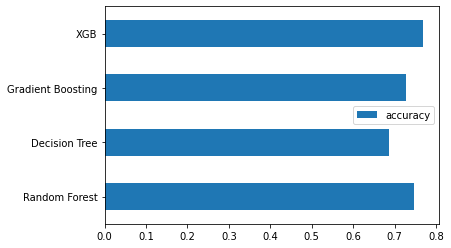

In [65]:
gs_model_compare = pd.DataFrame(grid_search_model_scores, index=["accuracy"])
gs_model_compare.T.plot.barh();


## Evaluting our tuned machine learning classifier, beyond accuracy

* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

## Top Performing models

1. RandomForestClassifier
2. XGBClassifier


### RandomForestClassifier

In [66]:
# Make predictions with tuned RandomForest model
y_preds = rf_mdl.predict(X_test)

In [67]:
y_test

10635    D
5496     A
13055    C
11826    C
1326     D
        ..
1472     B
8030     C
12738    A
9960     A
8545     C
Name: class, Length: 2679, dtype: object

In [68]:
# Confusion matrix
print(confusion_matrix(y_test, y_preds))

[[576 104   4   1]
 [130 420  88  24]
 [ 53 111 444  42]
 [  5  37  77 563]]


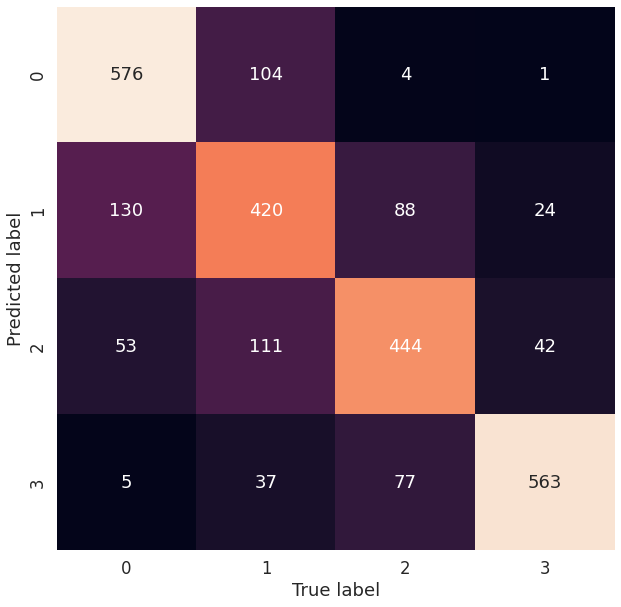

In [69]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False,
                     fmt='g')
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    bottom, top = ax.get_ylim()

    
plot_conf_mat(y_test, y_preds)

Now we've got a ROC curve, an AUC metric and a confusion matrix, let's get a classification report as well as cross-validated precision, recall and f1-score.

In [70]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           A       0.75      0.84      0.80       685
           B       0.62      0.63      0.63       662
           C       0.72      0.68      0.70       650
           D       0.89      0.83      0.86       682

    accuracy                           0.75      2679
   macro avg       0.75      0.75      0.75      2679
weighted avg       0.75      0.75      0.75      2679



### XGBClassifier

In [71]:
# Make predictions with tuned XGB model
y_preds = xgb_mdl.predict(X_test)

In [72]:
y_preds

array(['D', 'A', 'A', ..., 'B', 'A', 'C'], dtype=object)

In [73]:
# Confusion matrix
print(confusion_matrix(y_test, y_preds))

[[596  83   6   0]
 [131 429  81  21]
 [ 51 118 453  28]
 [  8  37  54 583]]


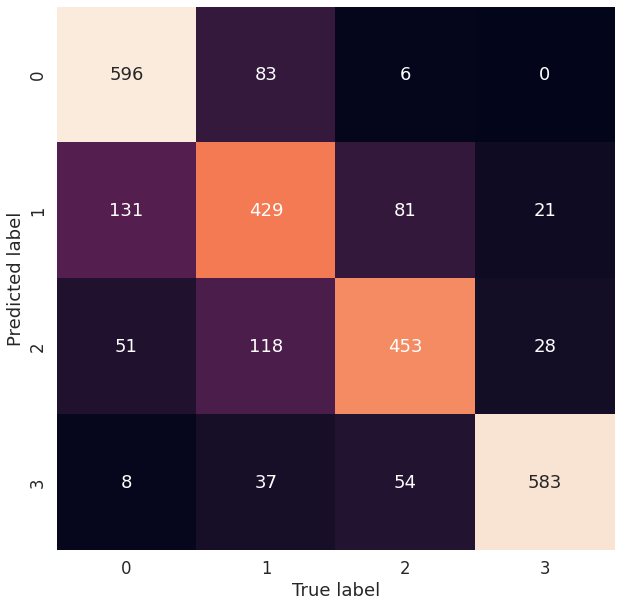

In [74]:
plot_conf_mat(y_test, y_preds)

In [75]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           A       0.76      0.87      0.81       685
           B       0.64      0.65      0.65       662
           C       0.76      0.70      0.73       650
           D       0.92      0.85      0.89       682

    accuracy                           0.77      2679
   macro avg       0.77      0.77      0.77      2679
weighted avg       0.77      0.77      0.77      2679



# SHAP Analysis

The summary plot gives a global picture and similar to feature importance plot of tress . Here how each feature impacts the model for each class is shown.

We are using the Linear Explainer for Shap analysis

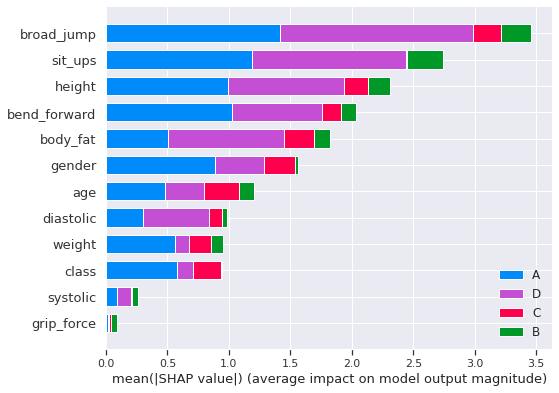

In [163]:

explainer = shap.LinearExplainer(lg_mdl, X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values,features=X_test, feature_names=df.columns, class_names=['A', 'B', 'C', 'D'])


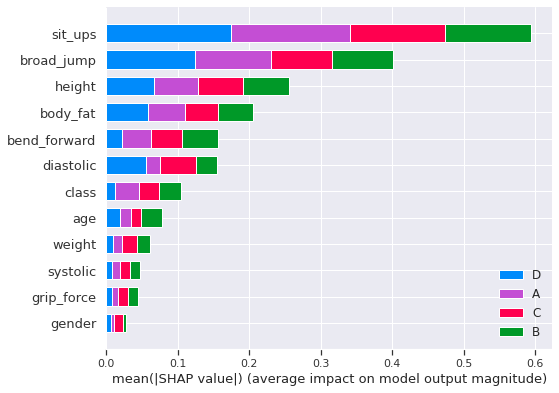

In [164]:
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values,features=X_test, feature_names=df.columns,  class_names=['A', 'B', 'C', 'D'])

`broad jumps`, `sit_up` increase the body performance to higher level

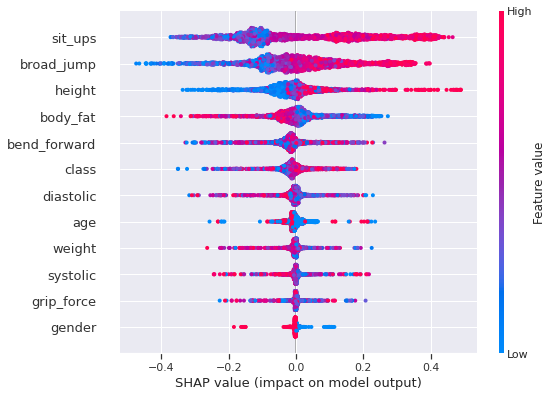

In [166]:
shap.initjs()
shap.summary_plot(shap_values[0], features=X_test, feature_names=df.columns)

Red denotes a low feature value, whereas blue denotes a high feature value. As we can see, low sit up and broad jumps values increase the likelihood of belonging to class D. Similarly, sit ups, broad jump, body, height values increase the likelihood of belonging to class A. 

## 6. AutoML

In [76]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=222

# Use 50% of availible resources
pct_memory=0.75
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

8
Checking whether there is an H2O instance running at http://localhost:22097 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpk2v6i_u7
  JVM stdout: /tmp/tmpk2v6i_u7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpk2v6i_u7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:22097
Connecting to H2O server at http://127.0.0.1:22097 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_unknownUser_ledrnj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [77]:
# Download the train data csv file and load in the training dataset 
train_url = "https://raw.githubusercontent.com/pratikg17neu/DS_6105/main/FinalProject/bodyPerformance.csv"
df = h2o.import_file(path = train_url)

pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [78]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [79]:
X = df_train.columns
print(X)

y = 'class'
X.remove(y)


aml.train(x=X,y=y,training_frame=df_train)  

['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic', 'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm', 'class']
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20220506_235838

No model summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.10674302170526564
RMSE: 0.32671550576191766

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.21213553662984824
RMSE: 0.4605817371866239

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.740506,0.013736,0.728160,0.742937,0.762454,0.729893,0.739087
1,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,err,0.259494,0.013736,0.271840,0.257063,0.237546,0.270107,0.260913
3,err_count,551.200000,32.896810,585.000000,555.000000,515.000000,581.000000,520.000000
4,logloss,0.630338,0.015221,0.636487,0.636265,0.603648,0.633482,0.641807
5,max_per_class_error,0.388012,0.021944,0.382812,0.367491,0.376838,0.388119,0.424797
6,mean_per_class_accuracy,0.739686,0.015176,0.726007,0.745031,0.763509,0.728940,0.734943
7,mean_per_class_error,0.260314,0.015176,0.273993,0.254969,0.236491,0.271060,0.265058
8,mse,0.212192,0.005299,0.216663,0.212659,0.203117,0.213480,0.215039
9,null_deviance,5892.363300,205.326000,5966.912000,5987.645500,6012.226600,5968.502400,5526.529300


In [80]:
print(aml.leaderboard)

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20220506_235838,0.260139,0.630129,0.460582,0.212136
StackedEnsemble_BestOfFamily_2_AutoML_1_20220506_235838,0.260229,0.635422,0.46219,0.213619
StackedEnsemble_BestOfFamily_1_AutoML_1_20220506_235838,0.260441,0.634455,0.461104,0.212616
GBM_1_AutoML_1_20220506_235838,0.264809,0.643163,0.466007,0.217162
GBM_3_AutoML_1_20220506_235838,0.270946,0.704571,0.49897,0.248971
GBM_4_AutoML_1_20220506_235838,0.272857,0.720574,0.505925,0.25596
GBM_2_AutoML_1_20220506_235838,0.273731,0.721891,0.507591,0.257649
XGBoost_1_AutoML_1_20220506_235838,0.277502,0.678651,0.474118,0.224788
XGBoost_2_AutoML_1_20220506_235838,0.278653,0.671236,0.477136,0.227659
DRF_1_AutoML_1_20220506_235838,0.310663,1.54056,0.508205,0.258273


In [81]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict


{'GBM_1_AutoML_1_20220506_235838': 3,
 'GLM_1_AutoML_1_20220506_235838': 10,
 'StackedEnsemble_AllModels_1_AutoML_1_20220506_235838': 0,
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20220506_235838': 2,
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20220506_235838': 1}

In [82]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

3


In [83]:
best_model.algo

'gbm'

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

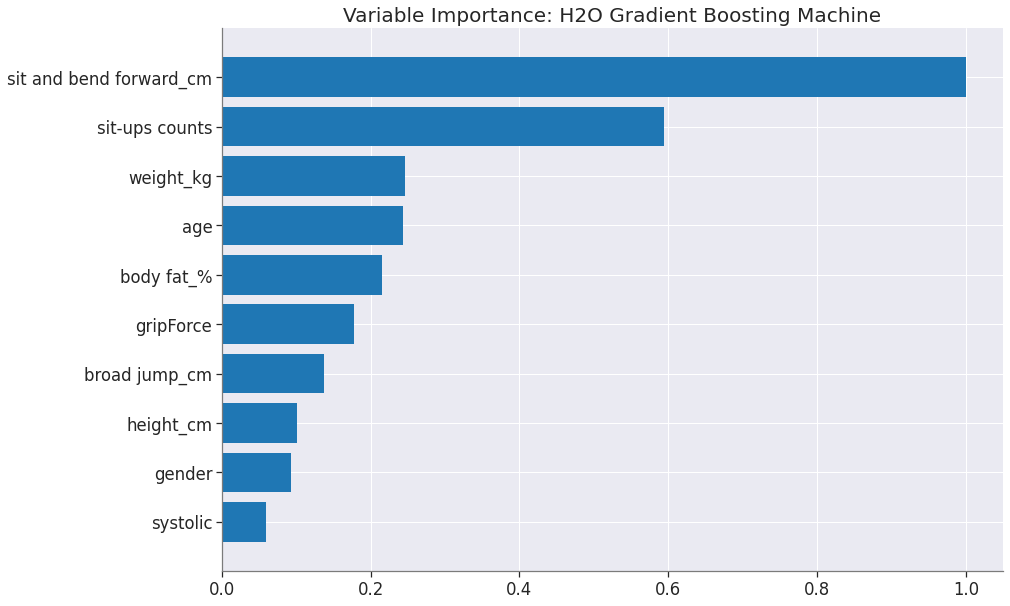

<Figure size 432x288 with 0 Axes>

In [85]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

In [86]:
best_model.algo

'gbm'

Using **GBM** Model suggested by AutoML

In [87]:
gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train, y_train)
gbm_model.score(X_test, y_test)

0.7278835386338186

Accuracy for GBM comes out to 72.78%

# 8. Using Keras

In [195]:
encoding = OrdinalEncoder()
encodedData = encoding.fit_transform(df)
encodedData = pd.DataFrame(encodedData)

In [196]:
variable = encodedData.copy()
col_name = variable[variable.columns[:-1]]

In [197]:
variable_set = np.array(variable)


In [198]:
keras_model = tf.keras.Sequential([
  layers.Dense(64),
  layers.Dense(11)
])

keras_model.compile(loss = tf.keras.losses.MeanSquaredError(), 
              optimizer = tf.optimizers.Adam(), 
              metrics=['accuracy'])

In [199]:
keras_model.fit(variable_set, col_name, epochs=50)


Epoch 1/15
419/419 [==============================] - 1s 2ms/step - loss: 6609.8970 - accuracy: 0.8239
Epoch 2/15
419/419 [==============================] - 1s 2ms/step - loss: 143.5995 - accuracy: 0.9859
Epoch 3/15
419/419 [==============================] - 1s 2ms/step - loss: 46.2409 - accuracy: 0.9925
Epoch 4/15
419/419 [==============================] - 1s 2ms/step - loss: 19.9968 - accuracy: 0.9948
Epoch 5/15
419/419 [==============================] - 1s 2ms/step - loss: 9.8459 - accuracy: 0.9966
Epoch 6/15
419/419 [==============================] - 1s 2ms/step - loss: 5.0826 - accuracy: 0.9977
Epoch 7/15
419/419 [==============================] - 1s 2ms/step - loss: 2.5395 - accuracy: 0.9984
Epoch 8/15
419/419 [==============================] - 1s 2ms/step - loss: 1.1892 - accuracy: 0.9989
Epoch 9/15
419/419 [==============================] - 1s 2ms/step - loss: 0.5144 - accuracy: 0.9990
Epoch 10/15
419/419 [==============================] - 1s 2ms/step - loss: 0.2051 - accuracy:

In [200]:
normalize = layers.Normalization()


In [201]:
normalize.adapt(variable_set)

In [203]:
norm_keras_model = tf.keras.Sequential([
  normalize,
  layers.Dense(64),
  layers.Dense(11)
])

norm_keras_model.compile(loss = tf.losses.MeanSquaredError(),
                           optimizer = tf.optimizers.Adam(),
                           metrics=['accuracy'])

norm_keras_model.fit(variable_set, col_name, epochs=50)

Epoch 1/50
419/419 [==============================] - 2s 3ms/step - loss: 75477.8047 - accuracy: 0.5419
Epoch 2/50
419/419 [==============================] - 1s 3ms/step - loss: 59951.0742 - accuracy: 0.6544
Epoch 3/50
419/419 [==============================] - 1s 3ms/step - loss: 41105.3789 - accuracy: 0.7040
Epoch 4/50
419/419 [==============================] - 1s 3ms/step - loss: 23560.4746 - accuracy: 0.7640
Epoch 5/50
419/419 [==============================] - 1s 3ms/step - loss: 12223.3506 - accuracy: 0.8056
Epoch 6/50
419/419 [==============================] - 1s 2ms/step - loss: 6158.3838 - accuracy: 0.8394
Epoch 7/50
419/419 [==============================] - 1s 2ms/step - loss: 3030.2800 - accuracy: 0.8699
Epoch 8/50
419/419 [==============================] - 1s 2ms/step - loss: 1585.0872 - accuracy: 0.9007
Epoch 9/50
419/419 [==============================] - 1s 2ms/step - loss: 1029.8898 - accuracy: 0.9240
Epoch 10/50
419/419 [==============================] - 1s 2ms/step -

# 9. Feature Importance on best model

In [168]:
xgb_mdl.feature_importances_

array([0.15382539, 0.15692778, 0.06638381, 0.03251783, 0.0577651 ,
       0.06512985, 0.02218748, 0.02352782, 0.05262658, 0.20383379,
       0.11641301, 0.04886154], dtype=float32)

In [169]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

In [173]:
# Match coef's of features to columns
feature_dict = dict(zip(df.columns, list(xgb_mdl.feature_importances_)))
feature_dict

{'age': 0.15382539,
 'bend_forward': 0.05262658,
 'body_fat': 0.0577651,
 'broad_jump': 0.11641301,
 'class': 0.048861545,
 'diastolic': 0.065129854,
 'gender': 0.15692778,
 'grip_force': 0.023527816,
 'height': 0.06638381,
 'sit_ups': 0.20383379,
 'systolic': 0.022187475,
 'weight': 0.032517828}

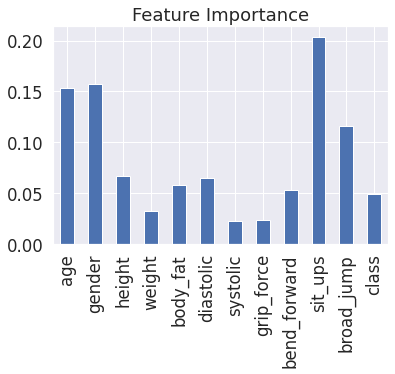

In [174]:
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False);

# Conclusion:

In this report we have peformed all the techinque learned in the course from data cleaning, feature scaling, shap value, AutoML and performed all the steps.

We trained our dataset on  multiple models also performed hyper parameter tuning using RandomSearchCV and GridSearchCV, and we find out that *XGBoost* Model has the highest accuracy, while when we use AutoML, AutoML suggests that *GBM* is the best, also we have performed SHAP analysis on the models and also deduced the feature importance which all tend to focus on `sit_up` and `broad_jump` are the most significant features for higher body performance grade. Also we have evaluation using `accuracy`, `classification report`, `precision` and `recall`

Also in the end we have use Keras model to increase the accuracy.

MIT License

 

Copyright (c) 2022 Pratik Gawand

 

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

 

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

 

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Reference

- https://shap.readthedocs.io/en/latest/tabular_examples.html
- https://github.com/aiprobably/SHAP
- https://www.youtube.com/watch?v=m60swo-th4E
- https://medium.com/dataman-in-ai/the-shap-values-with-h2o-models-773a203b75e3
- https://stackoverflow.com/
- https://www.analyticsvidhya.com/